In [ ]:
pip install chart-studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install -q -U tensorflow-addons

In [ ]:
import time
start_time=time.time()

Import necessary libraries


In [ ]:
import warnings
import numpy as np
import pandas as pd
import tensorflow
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.layers import Dropout

from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from chart_studio import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


LOAD DATA


In [ ]:
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])

One-hot Encoding

In [ ]:
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])

# create new column weekday
train['weekday'] = np.where(train['date'].dt.dayofweek < 5, 0, 1)
test['weekday'] = np.where(test['date'].dt.dayofweek < 5, 0, 1)
# perform one-hot encoding
train = pd.get_dummies(train, columns=['weekday'])
test = pd.get_dummies(test, columns=['weekday'])

#fill sales data with 0 in test set
test['sales'] = 0


MinMax Scaling

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Convert the 'date' column to datetime format
train['date'] = pd.to_datetime(train['date'])

# Create weekday and weekend indicator variables based on the 'date' column
train['weekday_weekend'] = np.where(train['date'].dt.weekday < 5, 'weekday', 'weekend')
# Select columns to be scaled
val_cols = ['store', 'item']
num_cols = ['sales']

# Scale the numerical columns using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 200))
train[num_cols] = scaler.fit_transform(train[num_cols])

# Add the 'date', 'store', and 'item' columns back to the dataset
train = train[['date'] + val_cols + num_cols + ['weekday_weekend']]


**Train** data description


In [ ]:
print(train.describe())
print(train.head())

               store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      45.238344
std         2.872283      14.430878      24.936055
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      25.974026
50%         5.500000      25.500000      40.692641
75%         8.000000      38.000000      60.606061
max        10.000000      50.000000     200.000000
        date  store  item      sales weekday_weekend
0 2013-01-01      1     1  11.255411         weekday
1 2013-01-02      1     1   9.523810         weekday
2 2013-01-03      1     1  12.121212         weekday
3 2013-01-04      1     1  11.255411         weekday
4 2013-01-05      1     1   8.658009         weekend


In [ ]:
import pandas as pd
# sort the 'date' column in each DataFrame in descending order
train = train.sort_values('date', ascending=True)
test = test.sort_values('date', ascending=True)

# extract the latest date from each DataFrame
train_last_date = train.iloc[-1]['date']
test_last_date = test.iloc[-1]['date']

# convert latest dates to datetime objects and format them as strings
train_last_date = pd.to_datetime(train_last_date).strftime('%Y-%m-%d')
test_last_date = pd.to_datetime(test_last_date).strftime('%Y-%m-%d')

In [ ]:
# Print minimum and maximum date of train set
print("Train set date range: {} to {}".format(train['date'].min(), train['date'].max()))

# Print minimum and maximum date of test set
print("Test set date range: {} to {}".format(test['date'].min(), test['date'].max()))

Train set date range: 2013-01-01 00:00:00 to 2017-12-31 00:00:00
Test set date range: 2018-01-01 00:00:00 to 2018-12-03 00:00:00


In [ ]:
# print the latest dates and the number of days between them
print("Train last date:", train_last_date)
print("Test last date:", test_last_date)
lag_size = (pd.to_datetime(test_last_date) - pd.to_datetime(train_last_date)).days
print("Number of days between train and test last dates:", lag_size)


Train last date: 2017-12-31
Test last date: 2018-12-03
Number of days between train and test last dates: 337


In [ ]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

In [ ]:
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
fig = go.Figure(data=[daily_sales_sc],layout=layout)
fig.show(renderer="colab")

In [ ]:
import plotly.io as pio
pio.renderers.default='notebook'

Reduce training set with the last year alone

In [ ]:
train = train[(train['date'] >= '2017-01-01')]
print(train.head())

             date  store  item      sales weekday_weekend
481699 2017-01-01      4    27  15.584416         weekend
695341 2017-01-01      1    39  31.168831         weekend
823161 2017-01-01      1    46  32.900433         weekend
523697 2017-01-01      7    29  37.229437         weekend
636909 2017-01-01      9    35  57.142857         weekend


Rearrange datasets to apply shift methods


In [ ]:
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1,1,2017-01-01,16.450216
1,1,1,2017-01-02,12.987013
2,1,1,2017-01-03,8.658009
3,1,1,2017-01-04,13.852814
4,1,1,2017-01-05,12.121212


Conversion of pandas data into supervised data

In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

forecast 90 days with current timesteps


In [ ]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+337),store(t+337),sales(t+337)
29,1.0,1.0,16.450216,1.0,1.0,12.987013,1.0,1.0,8.658009,1.0,...,13.852814,1.0,1.0,20.779221,1,1,7.792208,1.0,2.0,16.450216
30,1.0,1.0,12.987013,1.0,1.0,8.658009,1.0,1.0,13.852814,1.0,...,20.779221,1.0,1.0,7.792208,1,1,14.718615,1.0,2.0,17.316017
31,1.0,1.0,8.658009,1.0,1.0,13.852814,1.0,1.0,12.121212,1.0,...,7.792208,1.0,1.0,14.718615,1,1,12.987013,1.0,2.0,15.584416
32,1.0,1.0,13.852814,1.0,1.0,12.121212,1.0,1.0,20.779221,1.0,...,14.718615,1.0,1.0,12.987013,1,1,14.718615,1.0,2.0,17.316017
33,1.0,1.0,12.121212,1.0,1.0,20.779221,1.0,1.0,12.121212,1.0,...,12.987013,1.0,1.0,14.718615,1,1,20.779221,1.0,2.0,25.974026


drop items other than the shifted

In [ ]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

Remove unwanted columns


In [ ]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

train validation split

In [ ]:
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.2, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (134131, 30)
Validation set shape (33533, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
130551,113.419913,84.848485,100.432900,103.896104,104.761905,102.164502,121.212121,126.406926,78.787879,102.164502,...,119.480519,118.614719,88.311688,116.017316,77.056277,118.614719,107.359307,99.567100,109.090909,81.385281
88236,116.883117,98.701299,113.419913,124.675325,87.445887,79.653680,105.627706,90.909091,116.883117,123.809524,...,88.311688,110.822511,105.627706,105.627706,109.090909,69.264069,91.774892,100.432900,110.822511,122.077922
25818,67.532468,68.398268,82.251082,70.995671,77.922078,77.922078,73.593074,57.142857,77.056277,61.471861,...,80.519481,50.216450,64.069264,61.471861,73.593074,86.580087,98.701299,88.311688,62.337662,76.190476
14718,20.779221,22.510823,27.705628,15.584416,18.181818,14.718615,16.450216,12.987013,21.645022,20.779221,...,16.450216,17.316017,19.047619,24.242424,12.987013,16.450216,20.779221,18.181818,17.316017,18.181818
83337,25.974026,28.571429,45.021645,29.437229,28.571429,18.181818,34.632035,32.034632,27.705628,38.095238,...,36.363636,25.974026,35.497835,32.900433,46.753247,21.645022,21.645022,25.974026,36.363636,41.558442


In [ ]:
from keras import optimizers
epochs = 2
batch = 96
lr = 0.0001

For CNN parameters(samples,timesteps,features)

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (134131, 30, 1)
Validation set shape (33533, 30, 1)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, Reshape, TimeDistributed
from keras import optimizers

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=512, kernel_size=3, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(100, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1))
adam = optimizers.Adam(lr)
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 28, 512)           2048      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 14, 512)          0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 12, 256)           393472    
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 6, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 4, 128)            98432     
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 2, 128)         

Lstm

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import optimizers

model_lstm = Sequential()
model_lstm.add(LSTM(128, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2]), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(64, activation='relu'))
model_lstm.add(Dense(1))
adam = optimizers.Adam(lr)
model_lstm.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
model_lstm.summary()


"""from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense

model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_bilstm.add(Dense(1))
model_bilstm.compile(loss='mse', optimizer='adam')
model_bilstm.summary()
"""

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 30, 128)           66560     
                                                                 
 dropout_12 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_12 (LSTM)              (None, 64)                49408     
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


"from tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Bidirectional, Dense\n\nmodel_bilstm = Sequential()\nmodel_bilstm.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))\nmodel_bilstm.add(Dense(1))\nmodel_bilstm.compile(loss='mse', optimizer='adam')\nmodel_bilstm.summary()\n"

CNN-LSTM [sample,subsequences,timesteps,features]

In [ ]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (134131, 2, 15, 1)
Validation set shape (33533, 2, 15, 1)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, Reshape, TimeDistributed
from keras import optimizers

model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=256, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(128, activation='tanh'))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(Dense(1))
adam = optimizers.Adam(lr)
model_cnn_lstm.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
model_cnn_lstm.summary()

#model_cnn_lstm.compile(loss='mse', optimizer= tfa.optimizers.LazyAdam())

"""from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, TimeDistributed, Bidirectional, LSTM, Dense

model_cnn_bilstm = Sequential()
model_cnn_bilstm.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_bilstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_bilstm.add(TimeDistributed(Flatten()))
model_cnn_bilstm.add(Bidirectional(LSTM(50, activation='relu')))
model_cnn_bilstm.add(Dense(1))
model_cnn_bilstm.compile(loss='mse', optimizer='adam')
#model_cnn_bilstm.compile(loss='mse', optimizer= tfa.optimizers.LazyAdam())
model_cnn_bilstm.summary()
"""

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, None, 15, 256)    512       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 7, 256)     0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, None, 1792)       0         
 tributed)                                                       
                                                                 
 lstm_13 (LSTM)              (None, 128)               983552    
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                     

"from tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, TimeDistributed, Bidirectional, LSTM, Dense\n\nmodel_cnn_bilstm = Sequential()\nmodel_cnn_bilstm.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))\nmodel_cnn_bilstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))\nmodel_cnn_bilstm.add(TimeDistributed(Flatten()))\nmodel_cnn_bilstm.add(Bidirectional(LSTM(50, activation='relu')))\nmodel_cnn_bilstm.add(Dense(1))\nmodel_cnn_bilstm.compile(loss='mse', optimizer='adam')\n#model_cnn_bilstm.compile(loss='mse', optimizer= tfa.optimizers.LazyAdam())\nmodel_cnn_bilstm.summary()\n"

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/2
4192/4192 - 122s - loss: 1162.8480 - accuracy: 0.0000e+00 - val_loss: 562.3538 - val_accuracy: 0.0000e+00 - 122s/epoch - 29ms/step
Epoch 2/2
4192/4192 - 100s - loss: 447.9823 - accuracy: 0.0000e+00 - val_loss: 380.8421 - val_accuracy: 0.0000e+00 - 100s/epoch - 24ms/step


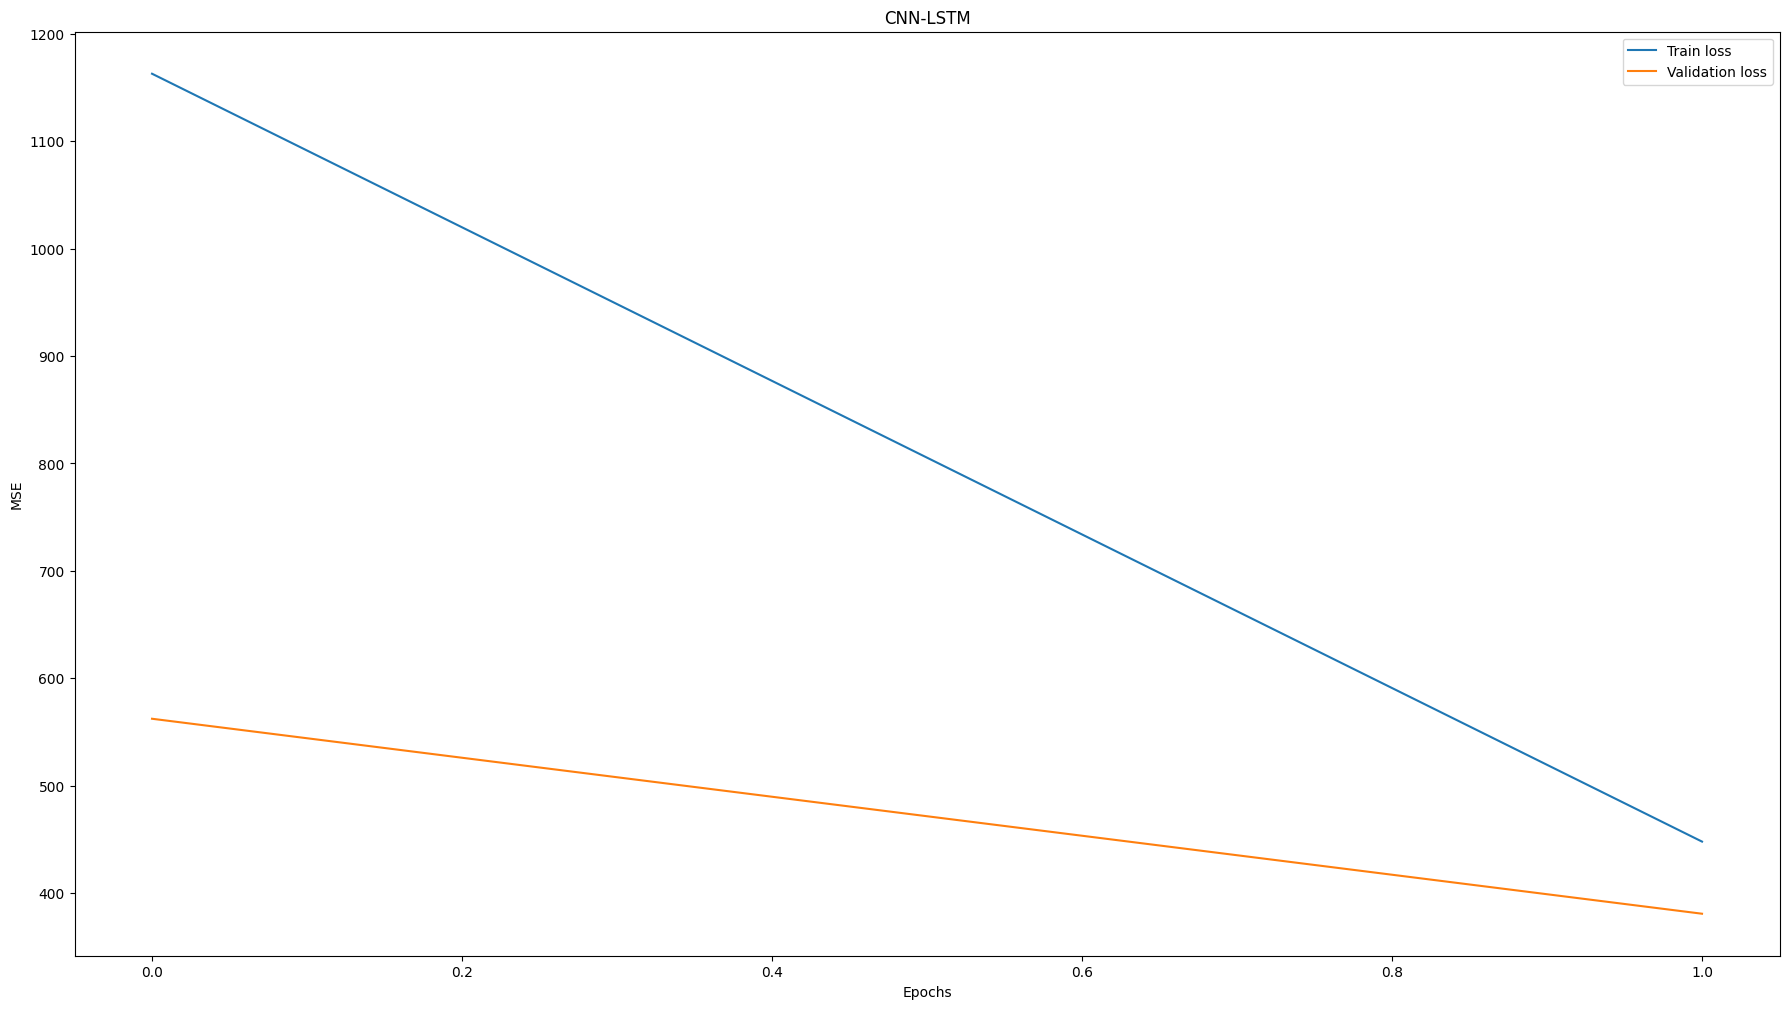

In [ ]:
fig, ax4 = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(22,12))

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

Calculating RMSE

In [ ]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)


print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

1048/1048 [==============================] - 9s 8ms/step
Train rmse: 19.50145580074512
Validation rmse: 19.515159853000686


In [ ]:
import numpy as np

# Define bin edges
bin_edges = np.arange(0, 240, 5)

# Bin the data
binned_data = np.histogram(Y_valid, bins=bin_edges)[0]

# Determine which bin each value belongs to
bin_indices = np.digitize(Y_valid, bin_edges)

# Bin the data
binned_data1 = np.histogram(cnn_lstm_valid_pred, bins=bin_edges)[0]

# Determine which bin each value belongs to
bin_indices1 = np.digitize(cnn_lstm_valid_pred, bin_edges)

# Define function to replace values with upper values of a bin
def replace_with_upper_values_rounded(values, bin_edges):
    # Determine which bin each value belongs to
    bin_indices = np.digitize(values, bin_edges)

    # Replace values between bin edges separated by 5 with their upper value
    upper_values = np.array([bin_edges[bin_index] if (bin_index < len(bin_edges)-1 and (values[i] - bin_edges[bin_index]) < 2.5) else bin_edges[bin_index+1] for i, bin_index in enumerate(bin_indices)])

    # Round to the nearest multiple of 10
    rounded_values = np.round(upper_values / 10) * 10

    return rounded_values


rounded_values = replace_with_upper_values_rounded(Y_valid, bin_edges)
rounded_values1 = replace_with_upper_values_rounded(cnn_lstm_valid_pred, bin_edges)

# Print the rounded values
print(rounded_values)
print(Y_valid)
print(rounded_values1)
print(cnn_lstm_valid_pred)



[60. 20. 50. ... 40. 20. 50.]
[61.47186147 24.24242424 45.88744589 ... 37.22943723 16.45021645
 47.61904762]
[[60.]
 [30.]
 [40.]
 ...
 [50.]
 [20.]
 [60.]]
[[60.737846]
 [25.565498]
 [44.534237]
 ...
 [45.712025]
 [22.523478]
 [57.84032 ]]


In [ ]:
df=pd.DataFrame(rounded_values1,rounded_values)
df.to_csv("result.csv")



In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

# Calculate metrics
accuracy = accuracy_score(rounded_values,rounded_values1)
precision = precision_score(rounded_values, rounded_values1, average='weighted')
recall = recall_score(rounded_values, rounded_values1, average='weighted')
f1 = f1_score(rounded_values, rounded_values1, average='weighted')
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Precision: {:.2f}%".format(precision*100))
print("Recall: {:.2f}%".format(recall*100))
print("F1 Score: {:.2f}%".format(f1*100))

Accuracy: 28.41%
Precision: 28.93%
Recall: 28.41%
F1 Score: 27.35%


Calculating Performance measures

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
mae = mean_absolute_error(Y_train, cnn_lstm_train_pred)
mape = mean_absolute_percentage_error(Y_train, cnn_lstm_train_pred) * 100
r2 = r2_score(Y_train, cnn_lstm_train_pred)
end_time=time.time()
execution_time=end_time-start_time

# Print the results
print("MAE: {:.4f}".format(mae))
print("MAPE: {:.2f}%".format(mape))
print("R-squared: {:.4f}".format(r2))
print("Execution time",execution_time)

MAE: 14.5699
MAPE: 34.48%
R-squared: 0.5030
Execution time -1681381929.49687
